## Stochastic Modelling and Simulation exam

Optimal vaccination strategies based on mean field epidemiologic modelling for HCov-Sars-2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import norm
import pandas as pd

In [2]:
df = pd.read_csv("../data/Popolazione_italiana.csv")
df_k_matrix = pd.read_csv("../data/KMatrixItalia.CSV", sep=";",header=None)
df_infected = pd.read_csv("../data/ReportISS_ICU.txt", sep="\t")
df_cases = pd.read_csv("../data/ReportISS_CumulativeCasesDeaths_age.txt", sep="\t")

### Contact matrix for age category

In [3]:
k_matrix_aggr = pd.DataFrame(columns=['0-9','10-19','20-29','30-39','40-49','50-59','60-69'])
for i in range(0,len(df_k_matrix[:-1]),2):
    temp = df_k_matrix[i:i+2].sum(axis=0)
    row = []
    for j in range(0,len(df_k_matrix[:-1]),2):
        row.append(temp[j:j+2].sum())
    
    k_matrix_aggr.loc[i//2] = row

col = []
for j in range(0, len(df_k_matrix[:-1]),2):
    temp = df_k_matrix[14][j:j+2]
    col.append(np.sum(temp))
    
k_matrix_aggr['70-79'] = col

row = []
for j in range(0, len(df_k_matrix[:-1]),2):
    temp = df_k_matrix[-1:].values[0]
    row.append(np.sum(temp[j:j+2]))
row.append(df_k_matrix[14][14])
k_matrix_aggr.loc[7] = row

In [4]:
#We make somewhat of a rough hypothesis: to spread the contact of the elders, we consider as if every category 70+
#would have the same number of contacts with other people

In [4]:
k_matrix_aggr['80-89'] = np.round(k_matrix_aggr['70-79']/3,decimals=2)
k_matrix_aggr['90+'] = np.round(k_matrix_aggr['70-79']/3,decimals=2)
k_matrix_aggr['70-79'] = np.round(k_matrix_aggr['70-79']/3,decimals=2)
k_matrix_aggr.loc[8] = k_matrix_aggr.loc[7]
k_matrix_aggr.loc[9] = k_matrix_aggr.loc[7]

In [5]:
K = k_matrix_aggr.values

### Immunological data

In [6]:
#Data obtained from "Immunological characteristics govern the transition of COVID-19 to endemicity"
#Suppose to divide the population into 1 bins 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90+
bins = 10
#Define the constant parameters
rho_1 = 1/9 #Average recovery time after infection: we assume it is constant with respect to age specificity
rho_2 = rho_1 * 5 
#We suppose recovering from second infection is 5 times as fast as recovering from first infection
#Check Lavine again for support regarding this assumption
beta = 0.05 #Secondary trasmissibility, can vary from 0.05-0.95 (Source: Lavine)
omega = 1/365 #One year of waning immunity. Again, could vary from 0.5 to 2 years.

#Define the age specific parameters
#The R0 parameter will be varied to explore different scenarios
IFR = np.array([0, 0, 0, 0.001, 0.002, 0.006, 0.029, 0.1, 0.196, 0.249]) #Source: https://lab24.ilsole24ore.com/coronavirus/#
WORLD_IFR = np.array([0, 0, 0, 0.001, 0.001, 0.003, 0.01, 0.02, 0.08, 0.08]) #Source https://www.acsh.org/news/2020/11/18/covid-infection-fatality-rates-sex-and-age-15163
f = IFR/(1-IFR) #Fraction of individuals that die
f = WORLD_IFR/(1-WORLD_IFR)
#http://www.salute.gov.it/portale/news/p3_2_1_1_1.jsp?lingua=italiano&menu=notizie&p=dalministero&id=4460
R0 = 3.60
R0_95cl = np.array([3.49, 3.84])

av_contacts = 19.77 #Based on the social study, averagin over a sample of italian population
alpha_av = rho_1 * R0 / av_contacts
alpha_95cl = rho_1/av_contacts * R0_95cl
alpha_bot = alpha_95cl[0]  
alpha_top = alpha_95cl[1]
alpha_sigma = (alpha_av - alpha_bot )/ 2
delta = f * rho_1 #Death rates: how do we model them? Idea, for each class we have and IFR. 
#This can be seen as infected_that_die/(infected_that_die + inf_that_recover). Hence, in order
#to have a race condition between recovery and death we need the ratio of the two rates to be the
#same of the IFR. I.e., if IFR is 50% then 1 individual recovers and 1 dies, hence the rates have
#to be equal

#### Population data

In [7]:
#Here we are extracting from the Istat data the value of the total italian population for age category that we need
italy_df = df.loc[df['Territorio'] == "Italia"]
age_tot = italy_df.loc[(italy_df['SEXISTAT1'] == 9) & (italy_df['STATCIV2'] == 99)]
df_age = pd.DataFrame(data=age_tot[['Età','Value']])
df_age.insert(2, "Age", [i for i in range(len(df_age))])
df_age.drop("Età", axis=1, inplace=True)
df_age.set_index('Age', inplace=True)
df_age.drop(index=101, inplace=True)
#age_cat_0 = [i//5 for i in range(10)]
#age_cat_1 = [2 + i//10 for i in range(91)]
#age_cat_1[-1] = age_cat_1[-2]
age_cat = [i//10 for i in range(101)]
age_cat[-1] = age_cat[-2]
df_age.insert(1, 'Age_category', age_cat)
age = df_age.groupby("Age_category").sum()
N = age.values
N = N[:,0]

Current infected and recovered

In [8]:
df_infected = df_infected[["AGE_GROUP", "CASI"]]
df_infected.loc[(df_infected.CASI == '<5'), 'CASI'] = 0
df_infected['CASI'] = pd.to_numeric(df_infected['CASI'])
df_infected = df_infected.groupby('AGE_GROUP').sum()
infected = df_infected.values[:-1,0]


df_cases.loc[(df_cases.DECEDUTI == '<5'), 'DECEDUTI'] = 0
df_cases = df_cases[df_cases.SESSO != 'Non noto']
df_cases = df_cases[df_cases.AGE_GROUP != 'Non noto']
df_cases['CASI_CUMULATIVI'] = pd.to_numeric(df_cases['CASI_CUMULATIVI'])
df_cases['DECEDUTI'] = pd.to_numeric(df_cases['DECEDUTI'])

df_cum_cases = df_cases[['AGE_GROUP', 'CASI_CUMULATIVI']]
df_cum_cases = df_cum_cases.groupby('AGE_GROUP').sum()

df_deads = df_cases[['AGE_GROUP', 'DECEDUTI']]
df_deads = df_deads.groupby('AGE_GROUP').sum()

cases = df_cum_cases.values[:,0]
deads = df_deads.values[:,0]

In [9]:
#Current data retrievable from https://lab24.ilsole24ore.com/coronavirus/#
N_tot = np.sum(N)
I10 = infected #TODO: take data from protezione civile if needed to start from the current picture
R10 =  cases-infected
R20 = np.zeros(bins)
I20 = np.zeros(bins)
D0 = deads
D0_tot = np.sum(D0)
S0 = (N-I10-R10-R20-I20-D0)

In [10]:
#This dict helps us keeping track of the name of the variables
var_names = dict()

for i in range(bins):
    var_names["s"+str(i)] = i
    var_names["i1"+str(i)] = i+bins
    var_names["r1"+str(i)] = i+bins*2
    var_names["r2"+str(i)] = i+bins*3
    var_names["i2"+str(i)] = i+bins*4
    var_names["d"+str(i)] = i+bins*5

### Vaccination policies

In [11]:
def no_vax(t,s,*args):
    
    cat = len(s)
    return np.zeros(cat)

def vax_old_first(t,s,cap=50000):
    #This function should model the vaccination with respect to time

    cat = len(s)
    vaccine = np.zeros(cat)
    vaccines_left = cap

    for i in range(cat-1,-1,-1):
        if s[i] > vaccines_left:
            vaccine[i] = cap
            return vaccine
        elif s[i] > 0:
            vaccine[i] = s[i]

    return vaccine

def vax_young_first(t,s, cap=50000):
    #This function should model the vaccination with respect to time
    
    cat = len(s)
    vaccine = np.zeros(cat)
    vaccines_left = cap

    for i in range(2,cat): #We should not vaccine kids anyway since they trasmit less than adolescents
        if s[i] > vaccines_left:
            vaccine[i] = cap
            return vaccine
        elif s[i] > 0:
            vaccine[i] = s[i]

    return vaccine

### Infection rate modelling

In [12]:
#We want to model how various policies affect the basic reproduction number. This means that we will evaluate how much contacts
#shift with given policies.

# 1. Masks: they cut by (suppose a) 50%  every chance of infection that we have: everyone should wear them, hence we apply this cut uniformly
# 2. School closures: some population (10-19, 20-29) are heavily affected by this: we cut by 50% also here
# 3. Smart working: adult population is affected: we cut by another 50%
# 4. Red zone: everyone should stay home: we reduce every category (except elders) to family members contact only

curr_K = K
time_dpcm = 0
dpcm = 0
dead_2_weeks_ago = 0

def max_K(d,t):
    return K

def masks(d,t):
    return K/2

def yellow_zone(d,t):
    new_K = K/3 #Masks are 70%ish percent efficient
    
    #School at half for young kids and teenagers
    new_K[0,0] = new_K[0,0]/2
    new_K[1,1] = new_K[1,1]/2
    
    #Smart working for 75% of people. Everyone with a mask at work (valid for adults 20-60)
    for i in range(2,6):
        for j in range(2,6):
            new_K[i,j] = new_K[i,j]/4
    
    return new_K

def red_zone(i1,t):
    #No school. Contacts between kids and teenagers set to 1.
    #Telework at 75%. The remaining has to wear a mask
    #Everyone else wears a mask and is more careful
    new_K = K/3
    new_K[0,0] = 1
    new_K[1,1] = 1
    
    for i in range(2,6):
        for j in range(2,6):
            new_K[i,j] = new_K[i,j]/4 #Takes into account impact of masks on existing contacts
        
    #Special caution with elders
    for i in range(7,bins):
        for j in range(bins):
            new_K[i,j] = new_K[i,j]/4
    
    for i in range(bins):
        for j in range(i+1, bins):
            new_K[i,j] = new_K.T[i,j]
    
    return new_K


def variable_zones(d,t, deaths_threshold = 5600):
    
    global dpcm 
    global time_dpcm
    global dead_2_weeks_ago
    global curr_K
    
    new_deaths = 0
    curr_deaths = np.sum(d)
    if (t-time_dpcm) > 14:
        new_deaths = curr_deaths - dead_2_weeks_ago
        dpcm = 0
    
    if dpcm == 0: 
        dpcm = 1
        time_dpcm = t
        dead_2_weeks_ago = curr_deaths
        if new_deaths > deaths_threshold:
            curr_K = red_zone(d,t)
        else :
            curr_K = yellow_zone(d,t)
    
    return curr_K    

### SIRRI: Vaccine yields sterilizing immunity

In [13]:
def unpack_sirri(X, categories):
    y = np.reshape(X, (-1, categories))
    return y[0,:], y[1,:], y[2,:], y[3,:], y[4,:], y[5,:]

def pack_sirri(ds, di1, dr1, dr2, di2, dd):
    return np.concatenate((ds, di1, dr1, dr2, di2, dd))

def sirri(X,t,vaccination, K_t, alpha=alpha_av, omega=omega, beta=beta, vaccine_capacity=50000,categories=10):
    '''
        This defines our model. It is a system of ordinary parameterized differential equations
        For the epidemiological meaning of the parameters please refer to immunological data
        section.
    '''
    
    s, i1, r1, r2, i2, d = unpack_sirri(X, categories)
    K = K_t(d,t)
    
    v = vaccination(t,s, vaccine_capacity)
    d_tot = np.sum(d)

    ds = dict()
    di1 = dict()
    di2 = dict()
    dr1 = dict()
    dr2 = dict()
    dd = dict()
    
    #The model
    for i in range(categories):
        ds[i] = -alpha*s[i]*(np.dot(i1/(N-d),K[i,:]) + beta*np.dot(i2/(N-d),K[i,:])) - v[i]
        di1[i] = alpha*s[i]*(np.dot(i1/(N-d),K[i,:]) + beta*np.dot(i2/(N-d),K[i,:])) - (1-f[i]) * rho_1 * i1[i] - delta[i]*i1[i]
        dr1[i] = (1-f[i]) * rho_1 * i1[i] + rho_2 * i2[i] - omega * r1[i] + v[i]
        dr2[i] = omega * r1[i] - alpha*s[i]*(np.dot(i1/(N-d),K[i,:]) + beta*np.dot(i2/(N-d),K[i,:]))
        di2[i] = alpha*s[i]*(np.dot(i1/(N-d),K[i,:]) + beta*np.dot(i2/(N-d),K[i,:])) - rho_2 * i2[i]
        dd[i] = delta[i] * i1[i]
    
                                           
    #print(di1)
                                           
    dX = pack_sirri(np.array(list(ds.values())),
              np.array(list(di1.values())),
              np.array(list(dr1.values())),
              np.array(list(dr2.values())),
              np.array(list(di2.values())),
              np.array(list(dd.values())))
    
    return dX

### Simulate solution with alpha sampled from a gaussian distribution 

In [14]:
def simul_sirri(N, days, omega=omega, beta=beta, vax_policy=vax_old_first, K_t=variable_zones, vaccine_cap=50000, cat=10):
    '''
        Creates a simulation for our epidemic model with fixed omega and beta and alpha variable
    '''
    avs = np.zeros([days, cat*6])
    avs_of_squared = np.zeros([days, cat*6])
    
    for i in range(N):
        a = norm.rvs(loc=alpha_av, scale = alpha_sigma)
        sol = simul_sirri_loop(days,vax_policy, K_t, a, vaccine_cap, cat, omega, beta)
        
        avs += sol
        avs_of_squared += sol ** 2
    
    avs = avs/N
    sigma = avs_of_squared/N - avs**2
    
    return avs, np.sqrt(sigma)
    
def simul_sirri_loop(days,vax_policy,K_t,alpha,vaccine_cap,cat, omega=omega, beta=beta):
    t = np.linspace(0,days,days)
    sol = odeint(sirri,pack_sirri(S0,I10,R10,R20,I20,D0),t,(vax_policy, K_t, alpha, omega, beta, vaccine_cap, cat))
    reset_global()
    return sol
    

In [15]:
def plot_sirri(sol, var_to_plot, title):

    n_var = len(var_to_plot)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(plt.cycler('color', ['r', 'g', 'b', 'c', 'm', 'y', 'k']))
    handles = []
    labels = []
    for i in var_to_plot:
        var = var_names[i]
        h, = ax.plot(t, sol[:,var])
        handles.append(h)
        labels.append(i)
        
    plt.legend(handles, labels)
    plt.title(title)
    plt.xlabel("time")
    plt.show()

In [16]:
def aggregate_sirri(sol, categories):
    
    n = sol.shape[0]
    s = np.zeros(n)
    i1 = np.zeros(n)
    r1 = np.zeros(n)
    r2 = np.zeros(n)
    i2 = np.zeros(n)
    d = np.zeros(n)
    
    for i in range(categories):
        s = s + sol[:,i]
        i1 = i1 + sol[:,i + categories] 
        r1 = r1 + sol[:,i + 2*categories]
        r2 = r2 + sol[:,i + 3*categories]
        i2 = i2 + sol[:,i + 4*categories]
        d = d + sol[:,i + 5*categories]
        
    return {"s":s, "i1":i1, "r1":r1, "r2":r2, "i2": i2, "d": d}
    

def plot_sirri_aggr(sol, st_dev, categories, title, var_to_plot=["s","i1","r1","r2","d"]):
    
    days = sol.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(plt.cycler('color', ['r', 'g', 'b', 'c', 'm', 'y', 'k']))
    handles = []
    labels = []
    var_dict = aggregate_sirri(sol, categories)
    sigma_dict = aggregate_sirri(st_dev, categories)
    t = np.linspace(0,days,days)
    
    for key in var_to_plot:
        var = var_dict[key]
        sigma = sigma_dict[key]
        h, = ax.plot(var)
        ax.fill_between(t, var - 2*sigma, var + 2*sigma, alpha=0.3)
        handles.append(h)
        labels.append(key)
        
    plt.legend(handles, labels)
    plt.title(title)
    plt.xlabel("time")
    plt.show()
    
    return var_dict, sigma_dict

def pack_aggr_data(var_dict, sigma_dict, label):
    return [var_dict, sigma_dict, label]

In [17]:
def reset_global():
    global curr_K 
    curr_K = K
    global time_dpcm 
    time_dpcm = 0
    global dpcm
    dpcm = 0

## Scenarios

### Vax elder first, varying zones

In [18]:
days = 365
sol,sol_sigma = simul_sirri(50, days, vax_policy=vax_old_first, K_t=variable_zones)

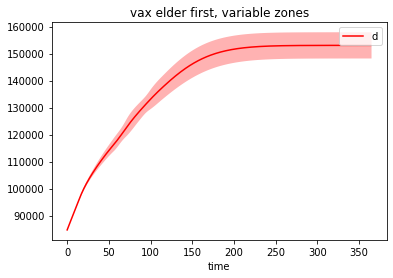

New deaths:  68325.0


In [20]:
agg_elders, agg_elders_sigma = plot_sirri_aggr(sol, sol_sigma, bins, "vax elder first, variable zones", ["d"])
elders_pack = pack_aggr_data(agg_elders, agg_elders_sigma, 'Vax elders first')
total_deaths = np.floor(max(agg_elders["d"]))
print("New deaths: ", total_deaths - np.sum(D0))

### Vax young first, varying zones

In [21]:
days = 365
sol,sol_sigma = simul_sirri(50, days, vax_policy=vax_young_first, K_t=variable_zones)

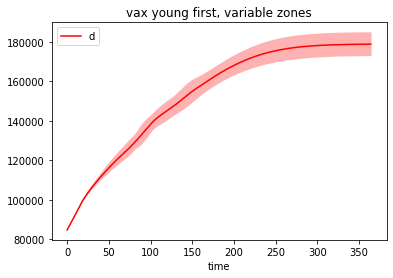

New deaths:  94114.0


In [22]:
agg_young, agg_young_sigma = plot_sirri_aggr(sol, sol_sigma, bins, "vax young first, variable zones", ["d"])
young_pack = pack_aggr_data(agg_young, agg_young_sigma, 'Vax young first')
total_deaths = np.floor(max(agg_young["d"]))
print("New deaths: ", total_deaths - np.sum(D0))

### Vax elders first, different omegas

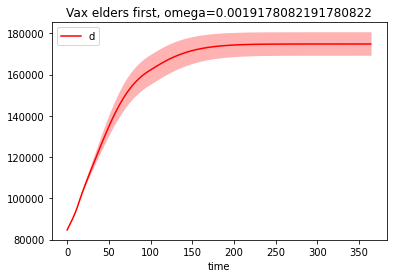

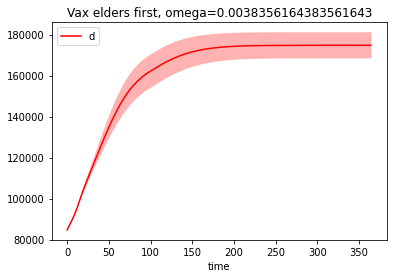

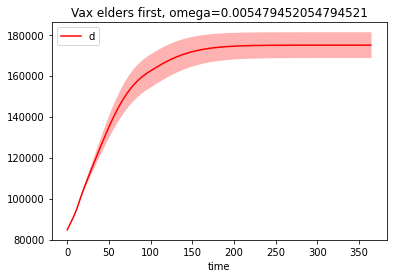

In [23]:
days = 365

omega_pack_elder = []

for om in np.array([0.7/365,1.4/365,2/365]):
    sol,sol_sigma = simul_sirri(50, days, omega=om, beta=0.9, vax_policy=vax_old_first, K_t=variable_zones)
    agg, agg_sigma = plot_sirri_aggr(sol, sol_sigma, bins, "Vax elders first, omega="+str(om), 'd')
    pack = pack_aggr_data(agg, agg_sigma, "Omega="+str(om))
    omega_pack_elder.append(pack)

### Vax young first different omegas

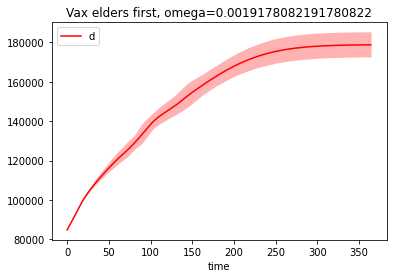

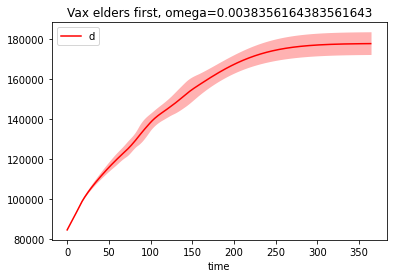

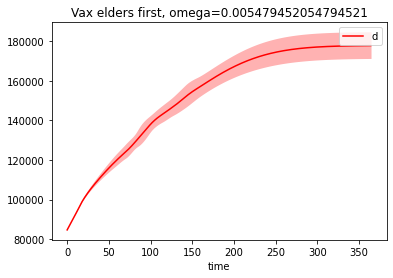

In [24]:
days = 365

omega_pack_young = []

for om in np.array([0.7/365,1.4/365,2/365]):
    sol,sol_sigma = simul_sirri(50, days, omega=om, vax_policy=vax_young_first, K_t=variable_zones)
    agg, agg_sigma = plot_sirri_aggr(sol, sol_sigma, bins, "Vax elders first, omega="+str(om), 'd')
    pack = pack_aggr_data(agg, agg_sigma, "Omega="+str(om))
    omega_pack_young.append(pack)

### Vax elders first, different beta

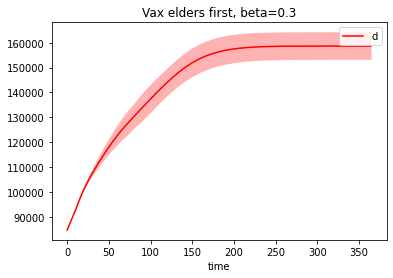

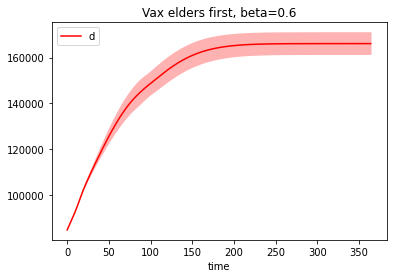

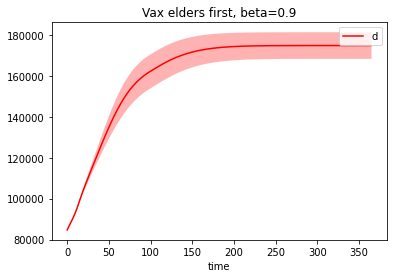

In [25]:
days = 365

beta_pack_elders = []

for bet in np.array([0.3,0.6,0.9]):
    sol,sol_sigma = simul_sirri(50, days, beta=bet, vax_policy=vax_old_first, K_t=variable_zones)
    agg, agg_sigma = plot_sirri_aggr(sol, sol_sigma, bins, "Vax elders first, beta="+str(bet), 'd')
    pack = pack_aggr_data(agg, agg_sigma, "Beta="+str(bet))
    beta_pack_elders.append(pack)

### Vax young first, different beta

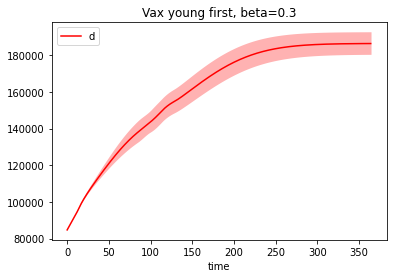

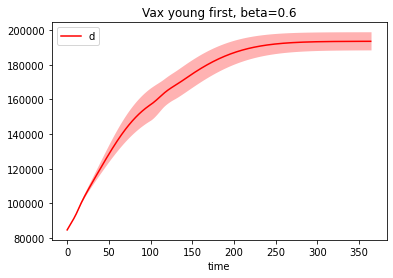

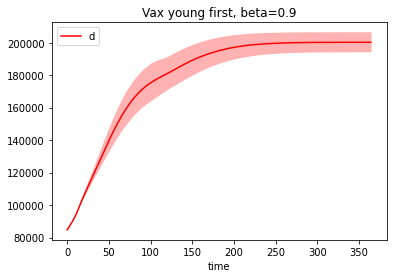

In [26]:
days = 365

beta_pack_young = []

for bet in np.array([0.3,0.6,0.9]):
    sol,sol_sigma = simul_sirri(50, days, beta=bet, vax_policy=vax_young_first, K_t=variable_zones)
    agg, agg_sigma = plot_sirri_aggr(sol, sol_sigma, bins, "Vax young first, beta="+str(bet), 'd')
    pack = pack_aggr_data(agg, agg_sigma, "Beta="+str(bet))
    beta_pack_young.append(pack)

### Comparative plots

In [32]:
def compare_scenarios(*args, title, days=365, ldd=391, compartment='d'):
    '''
    This function takes in input list of the type
    [data, error on data, label of data]
    
    and produces a comparative plot with respect to the indicated compartment variable
    '''
    
    last_day_deaths = ldd
    t = np.linspace(0,days,days)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    handles = []
    labels = []
    
    for data_list in args:
        data = data_list[0][compartment]
        data_sigma = data_list[1][compartment]
        data_label = data_list[2]      
        h1, = plt.plot(data)
        ax.fill_between(t, data + 2*data_sigma, data - 2*data_sigma, alpha=0.2)
        handles.append(h1)
        labels.append(data_label)
    
    plt.xlabel('Days')
    plt.title(title)
    plt.legend(handles, labels)
    plt.savefig(title)
    plt.show()

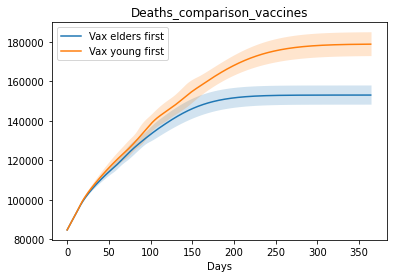

In [33]:
compare_scenarios(elders_pack, young_pack, title="Deaths_comparison_vaccines")

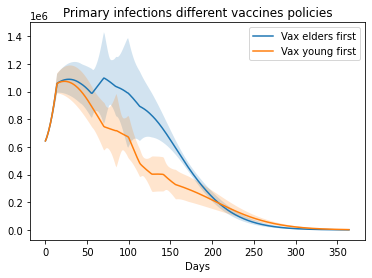

In [34]:
compare_scenarios(elders_pack, young_pack, title="Primary infections different vaccines policies", compartment='i1')

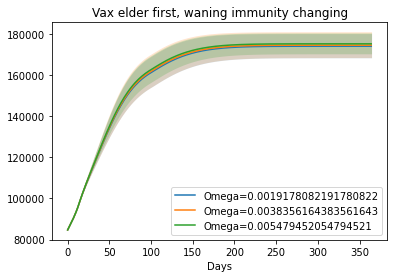

In [ ]:
compare_scenarios(omega_pack_elder[0], 
                  omega_pack_elder[1],
                  omega_pack_elder[2],
                  title = "Vax elder first, waning immunity changing")

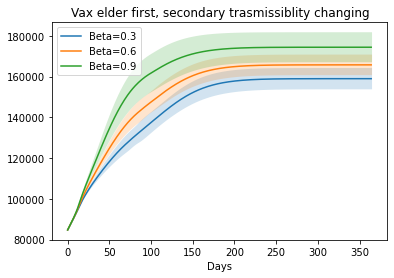

In [ ]:
compare_scenarios(beta_pack_elders[0], 
                  beta_pack_elders[1],
                  beta_pack_elders[2],
                  title = "Vax elder first, secondary trasmissiblity changing",
                  compartment='d')

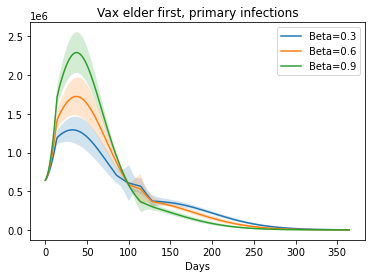

In [ ]:
compare_scenarios(beta_pack_young[0], 
                  beta_pack_young[1],
                  beta_pack_young[2],
                  title = "Vax elder first, primary infections",
                  compartment='i1')

### Vaccine young vs vaccine old with respect to vaccine capacity and death thresholds for red zone

In [ ]:
days = 365*2
t = np.linspace(0,days,days+1)
capacity = [i for i in range(30000,100000,2000)]
deaths_old = []
deaths_young = []

for cap in capacity:
    sol = odeint(sirri,pack_sirri(S0,I10,R10,R20,I20,D0),t,(vax_old_first, variable_zones, cap))      
    agg = aggregate_sirri(sol, bins)
    deaths_vax_old = np.round(agg['d'][-1])
    reset_global()
    sol = odeint(sirri,pack_sirri(S0,I10,R10,R20,I20,D0),t,(vax_young_first, variable_zones, cap))      
    agg = aggregate_sirri(sol, bins)
    deaths_vax_young = np.round(agg['d'][-1])
    deaths_old.append(deaths_vax_old)
    deaths_young.append(deaths_vax_young)
    reset_global()

In [ ]:
fig = plt.figure()  
ax = fig.add_subplot(111)
deaths_old = np.array(deaths_old)
deaths_young = np.array(deaths_young)
y = deaths_young - deaths_old
h1, = ax.plot(capacity, deaths_old,)
h2, = ax.plot(capacity, deaths_young)
plt.title("Cumulative Deaths with two different vaccination policies")
plt.xlabel("Vaccine per day")
plt.legend([h1,h2], ["Elder first", "Young first"])
plt.savefig("Presentation/Images/Deaths_with_capacity")
plt.show()